Import dependencies

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import os, json, glob
from collections import defaultdict


Construct the path to the folder containing the datasets

In [22]:
PATH = (Path(os.getcwd()) / "../data").resolve()
PATH

PosixPath('/home/david/dev/icl-mq/toothbrushing-dataset/data')

Helper functions to read dataset into a pandas dataframe from the seperate files

In [25]:
def read_file(filename:str):
    """
    Each file should have the same structure

    epoch, timestamp and elapsed columns reprenting sample time and 3 data channels
    """

    # read raw file
    df=pd.read_csv(filename)

    # drop unused columns
    df = df.drop(["epoc (ms)","elapsed (s)"],axis=1)

    # convert timestamp to datetime
    df["timestamp"] = pd.to_datetime(df["timestamp (+1000)"], format='%Y-%m-%dT%H.%M.%S.%f')

    df = df.drop(["timestamp (+1000)"],axis=1)

    # index on timestamp
    df = df.set_index("timestamp")

    return df

def interpolate(df, new_index, limit=1):
    """
    Use zero order hold interpolation
    """
    return df.reindex(df.index | new_index).fillna(method='ffill', limit=limit).loc[new_index]

def read_sensor_data(
    path:str,                  # location of experiments
    experiment:str,            # experiment folder
    device:str,                # name of device (W1, W2)):
    freq="5L",                 # "5L" = 5ms = 200Hz
    ) ->  pd.DataFrame:         
    """ loads raw sensor data into dataframe """
    experiment_path = os.path.join(path, experiment)
    accelerometer_filename = glob.glob(os.path.join(experiment_path, f"*{device}*_Accelerometer.csv"))[0]
    gyroscope_filename = glob.glob(os.path.join(experiment_path, f"*{device}*_Gyroscope.csv"))[0]
    magnetometer_filename = glob.glob(os.path.join(experiment_path, f"*{device}*_Magnetometer.csv"))[0]

    # read the three sensors
    accelerometer = read_file(accelerometer_filename)
    gyroscope = read_file(gyroscope_filename)
    magnetometer = read_file(magnetometer_filename)

    # in order to join we need to resample and interpolate
    start = np.max([
        accelerometer.index.min().ceil(freq), 
        gyroscope.index.min().ceil(freq), 
        magnetometer.index.min().ceil(freq)
        ])
    end = np.min([
        accelerometer.index.max().floor(freq), 
        gyroscope.index.max().floor(freq), 
        magnetometer.index.max().floor(freq)
        ])
    new_index = pd.date_range(start, end, freq=freq)

    accelerometer = interpolate(accelerometer, new_index)
    gyroscope = interpolate(gyroscope, new_index)
    magnetometer = interpolate(magnetometer, new_index, limit=10) # sample rate is 1/10th of the other 2 sensors

    df = pd.concat((
        accelerometer,
        gyroscope,
        magnetometer
        ), axis=1)
    return df

def load_dataset(
    path:str,
    experiment:str, 
    device:str,
    timezone:str="Australia/Sydney",
    freq:str="5L"
    ):
    # load data
    df = read_sensor_data(path=path,experiment=experiment,device=device,freq=freq)
    df.index = df.index.tz_localize(timezone)
    df.index.name = 'timestamp'

    # load labels
    filename = os.path.join(path, experiment, f'labels.json')
    with open(filename, 'r') as fp:
        labels = json.load(fp)

    labels = pd.DataFrame.from_dict(labels, orient='index', columns=["from","to"])
    labels["from"] = pd.to_datetime(labels["from"]).dt.tz_convert(timezone) # have to convert from fixed offset
    labels["to"] = pd.to_datetime(labels["to"]).dt.tz_convert(timezone)
    labels = labels.sort_values("from")

    # locate the activities
    start = labels["from"].min()
    end = labels["to"].max()
    df = df[start:end]

    # label the activities
    start_idx = np.searchsorted(labels["from"].values, df.index.values)-1
    end_idx = np.searchsorted(labels["to"].values, df.index.values)
    mask = (start_idx == end_idx)

    df['label']=None
    df.loc[mask,'label']=labels.index[start_idx[mask]]
    df["label"]=df["label"].bfill() # hack mainly to fix first row missing label

    return df.drop("label", axis=1), df["label"]

In [41]:
experiment ="sample"
device="W2"

data, labels = load_dataset(PATH, experiment, device)

`data` contains one column per sensor axis resampled at 200Hz

In [42]:
data.head()

,x-axis (g),y-axis (g),z-axis (g),x-axis (deg/s),y-axis (deg/s),z-axis (deg/s),x-axis (T),y-axis (T),z-axis (T)
timestamp,,,,,,,,,
2020-08-09 11:06:33.035000+10:00,0.470,-0.631,-0.282,-61.037,-29.878,2.683,-0.002048,-0.002048,0.002048
2020-08-09 11:06:33.040000+10:00,0.137,-1.193,-0.377,-52.805,-21.951,5.366,-0.002048,-0.002048,0.002048
2020-08-09 11:06:33.045000+10:00,0.376,-0.605,-0.014,-46.098,-22.622,-9.207,-0.002048,-0.002048,0.002048
2020-08-09 11:06:33.050000+10:00,0.660,-0.685,-0.086,-70.915,-20.183,0.000,-0.002048,-0.002048,0.002048
2020-08-09 11:06:33.055000+10:00,0.417,-1.181,0.068,-79.878,-3.659,1.585,-0.002048,-0.002048,0.002048


In [43]:
df.describe()

,x-axis (g),y-axis (g),z-axis (g),x-axis (deg/s),y-axis (deg/s),z-axis (deg/s),x-axis (T),y-axis (T),z-axis (T)
count,22170.000000,22170.000000,22170.000000,22170.000000,22170.000000,22170.000000,22169.000000,22169.000000,2.216900e+04
mean,0.423360,-0.091309,0.041731,4.543694,-0.138663,0.353845,-0.002048,-0.002048,2.047938e-03
std,0.284608,0.737401,0.708868,52.263989,16.669657,15.410290,0.000000,0.000000,4.336907e-19
min,-0.848000,-3.500000,-1.936000,-440.671000,-210.732000,-72.073000,-0.002048,-0.002048,2.047938e-03
25%,0.242000,-0.668000,-0.594000,-11.935750,-9.878000,-8.780000,-0.002048,-0.002048,2.047938e-03
50%,0.424000,-0.122000,0.063000,0.549000,-0.366000,-0.305000,-0.002048,-0.002048,2.047938e-03
75%,0.609000,0.503000,0.635750,14.634000,9.634000,8.780000,-0.002048,-0.002048,2.047938e-03
max,1.512000,2.459000,2.427000,803.110000,139.390000,139.939000,-0.002048,-0.002048,2.047938e-03


`labels` contains the text label for each sample

In [44]:
labels.head()

timestamp
2020-08-09 11:06:33.035000+10:00    Left Lower Jaw Front
2020-08-09 11:06:33.040000+10:00    Left Lower Jaw Front
2020-08-09 11:06:33.045000+10:00    Left Lower Jaw Front
2020-08-09 11:06:33.050000+10:00    Left Lower Jaw Front
2020-08-09 11:06:33.055000+10:00    Left Lower Jaw Front
Name: label, dtype: object

In [45]:
df = pd.concat([data,labels], axis=1)

Text(0.5, 0.92, 'sample')

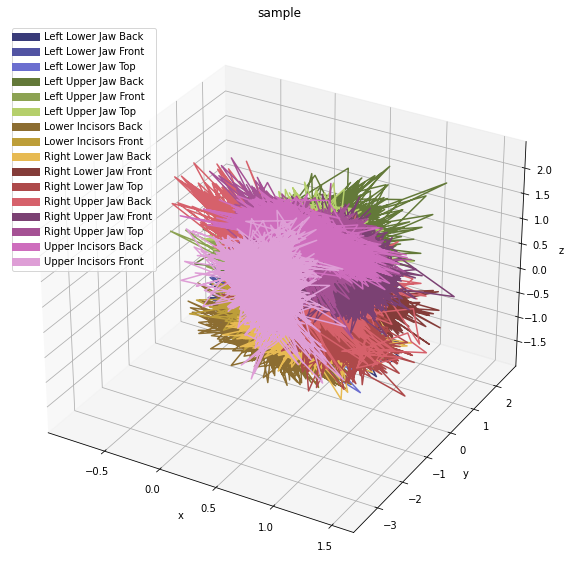

In [47]:
# https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib
import matplotlib.cm as mplcm
import matplotlib.colors as colors

labels = df['label'].unique()
labels.sort()
assert len(labels)==16

x = data[["x-axis (g)", "y-axis (g)", "z-axis (g)"]].values

cm = plt.get_cmap('tab20b')
cNorm  = colors.Normalize(vmin=0, vmax=len(labels)-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(111, projection='3d')
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(len(labels))])
for label in labels:
    mask = df['label']==label
    ax.plot(xs=x[mask,0], ys=x[mask,1], zs=x[mask,2], zdir='z', label=label)
l = ax.legend()
for line in l.get_lines():
    line.set_linewidth(8.0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_title(experiment)
    